# How to delta hedge an option: Part V

## Which volatility do I use?

So far we have built up a world in order to analyse the effectiveness of delta hedging for the replication of a vanilla option. We have stated a simple model for how a stock moves around:
 - it drifts a bit
 - has a nice simple normally distributed change every day

Based on that representation of the world we have then introduced (without much explanation) the Black-Scholes equation for pricing an option and also computing the delta that we use to hedge it.

We then showed that with a bit of python we can simulate `10,000` replications to see that:
 - in general the delta hedged replication works with some hedging error
 - that hedging error seems to be proportional to how frequently we hedge
 - that hedging error appears to be greatest for stock price paths that finish around our option's strike

As mentioned before, the only mind boggling thing about it working is perhaps that I managed to code it up in python without errors. This is because we have deliberately set up our stock price world _exactly according to the assumptions stated by Black-Scholes_. The only assumption we have violated is that of continuous hedging; however we showed that if we were to increase our hedging frequency, then hedging error tends to zero and we have truly created a riskless replication of a vanilla option.

In other words, we've created an incredibly stylised world to get some nice pretty graphs and come to the conclusion that delta hedging alone reduces risk with vanilla options to zero. Before starting to look into the distributional assumptions (cough cough, normal distribution), let's have a look at some of the pnl dynamics of our delta hedged simulations. In particular let's have a look at the question:

_"Which volatility should I use to delta hedge my option and what happens if this is a different number than the realised volatility that actually materialises?"_

## Gamma vs Theta

There's a lovely bit at the start of most volatility surface modelling text books ([first few pages of Bergomi my favourite](https://www.lorenzobergomi.com/)) that shows how in a non-stochastic volatility world the daily pnl of a deltavhedged option position breaks down into the comparison of realised volatility vs implied volatility.

Assuming you have bought an option and are delta hedging it then if a daily observation of realised volatility is higher than the implied volatility of the option then you will have made money that day. Vice versa, if the realised has 'underperformed' the implied then you will have lost.

This is usually called the 'gamma/theta trade-off' and is a break-even statement - on a long option position you lose money on the decay of the time value of the option daily (based on the implied volatility) and you make money on the delta hedging of the option through the delta change (gamma) when the underlying stock moves (based on the realised volatility). The more the stock moves the more money you make delta-hedging and as long as this is a relatively large move compared to the implied volatility then you won't pay as much decay in comparison.

When viewed like this then it's very clear that vanilla options trading can be viewed as volatility trading - the idea is to buy options if you think realised volatility will be higher than the implied they are priced on and sell them if lower. The next question becomes:

## How much money will I make?

Let's say you think realised will be higher than implied volatility for a given option you have your eye on: and you happen to be right. How do you know how much money you will make from the process of:
 - buying the option
 - delta hedging the option
 - profiting from making more money on the delta hedging than you lose on the option time value decaying

and does this depend on the volatility we use to compute our daily deltas for hedging? Let's try a few simulations.

## Set the scene

To start let's assume the following. We see an option that we like the look of that has an implied vol of `20`. We think that's 'cheap' because we expect the realised vol from now until the expiry of the option to be a juicy `30` (10 vols higher!!!). Both these numbers are annualised volatilities. What happens if we buy the option, delta hedge it and:
 - use the implied volatility of `20` to compute our delta hedge every day?
 - use the realised volatility of `30` to compute our delta hedge every day?

__Here we are making another heroic assumption that we know the realised volatility that will play out over the course of the option's life already__, but that's fine for now. To keep things simple we'll assume it's a `T=1` year option with strike `K=100` and starting stock price of `S=100`.

To try to minimise the contribution of hedging error (because we are not continuously hedging) we will hedge 4x per day. Let's generate the stock paths and show them for completeness.

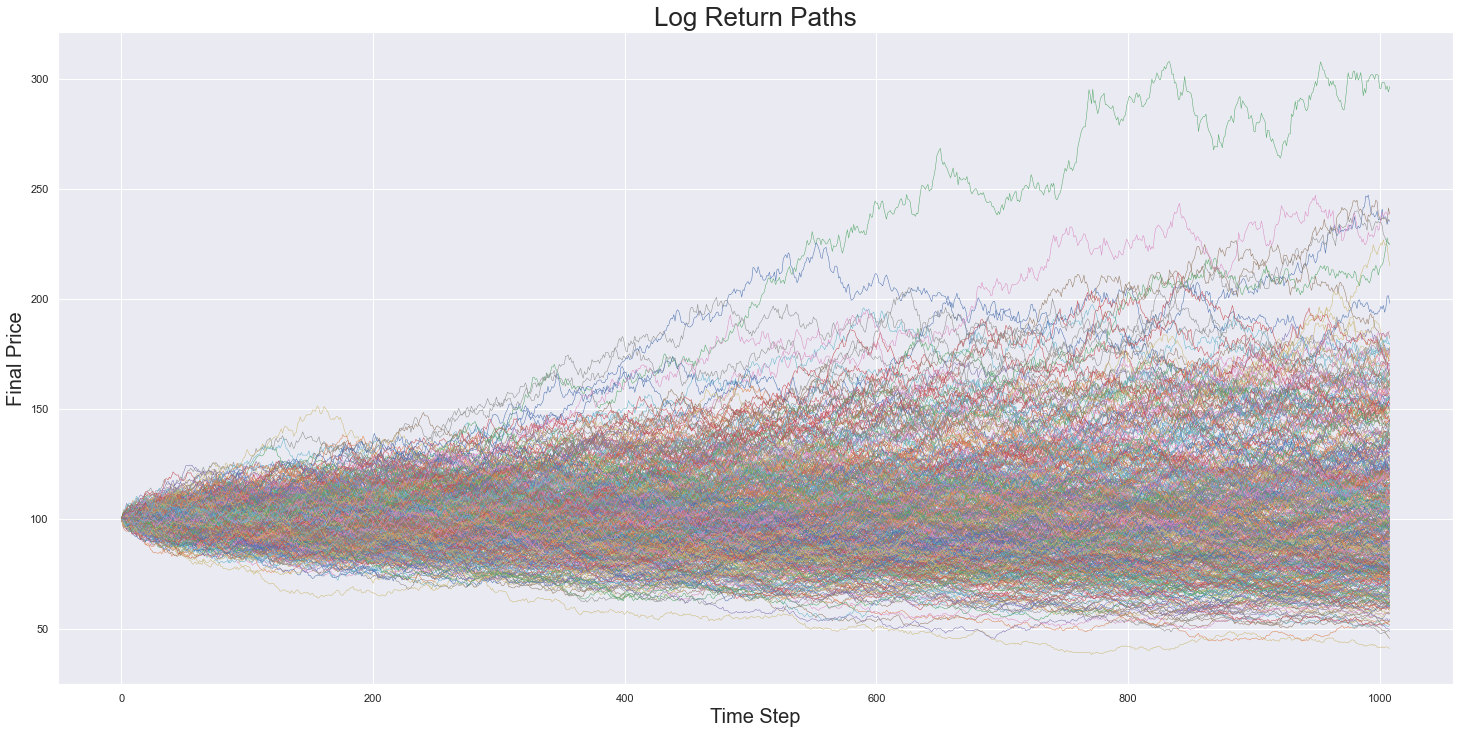

In [15]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# packaged up replication code
from opcoes.replication import run_delta_hedge_sim

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set() 

# set our simulation settings
sims = 10000

px = 100
strike = 100
risk_free = 0.00
divs = 0.00
sigma = 0.30
years = 1
points = 252*4

# set implied vol and use that as vol to compute hedge
iv = 0.20
hedge_vol = 0.20

# compute all replication data
pxs, rets, call_pxs, repls, deltas, gammas = run_delta_hedge_sim(px, strike, risk_free, divs, sigma, years, points, sims, iv=iv, hedge_vol=hedge_vol)

# plot them
fig, ax = plt.subplots(figsize=(25,12))

for p in pxs[:500]:
    ax.plot([z for z in range(0, points*years+1)], p, linewidth=0.5)
    
ax.set_title('Log Return Paths', fontsize=26)
ax.set_xlabel('Time Step', fontsize=20)
ax.set_ylabel('Final Price', fontsize=20);

So far so good. We have the standard log normally distributed setup where we have a similar number of paths doubling (going to `200`) as we have halving (going to `50`).

## Hedging using Implied Volatility

Now just as we had before with our 'hedging error' graphs in Part IV, let's see how the replication, __computed using the implied volatility__, compares to the terminal payoff of the option. We'll both compute a scatterplot of the pnl according to the final underlying price as well as display a few sample paths of how that pnl evolved over time.

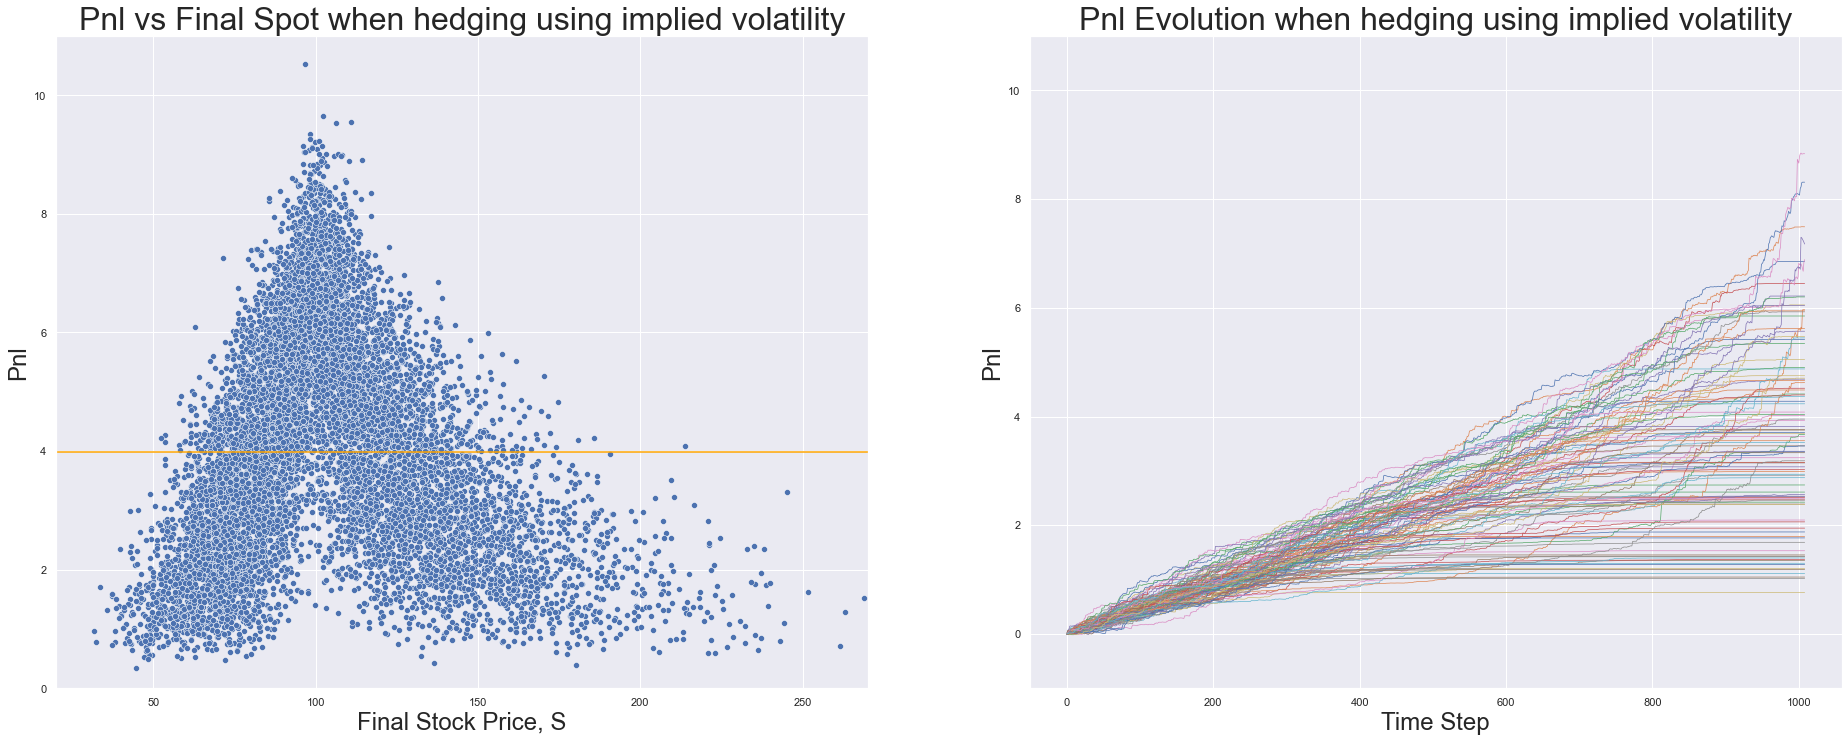

In [16]:
prices = pxs[:, -1]
call_prices = call_pxs[:, -1]
repl_pxs = repls[:, -1]

fig, axes = plt.subplots(ncols=2, figsize=(32,12))
axes = axes.reshape(-1)

sns.scatterplot(prices, call_prices - repl_pxs, ax=axes[0])

axes[0].axhline(np.mean(call_prices - repl_pxs), color='orange')
axes[0].set_title('Pnl vs Final Spot when hedging using implied volatility', fontsize=32)
axes[0].set_xlabel('Final Stock Price, S', fontsize=24)
axes[0].set_ylabel('Pnl', fontsize=24)
axes[0].set_xlim(20, 270)
axes[0].set_ylim(0, 11)

pd.DataFrame(call_pxs[:100, :] - repls[:100, :]).T.plot(ax=axes[1], legend=False, lw=0.7)
axes[1].set_title('Pnl Evolution when hedging using implied volatility', fontsize=32)
axes[1].set_xlabel('Time Step', fontsize=24)
axes[1].set_ylabel('Pnl', fontsize=24)
axes[1].set_ylim(-1, 11);

So on the left we have what we had before. Each dot represents the pnl for a simulation according to where the stock price ended up in that simulation. We can make a few observations:
 - even though the realised volatility is the same for each simulation, the final pnl is clearly not
 - the pnl distribution appears to be peaked around the strike of the option: those paths that finished at the strike seem to have generated the most pnl
 - at least all simulations generated positive pnl

On the right we can see for `100` of the simulations the journey the pnl took to end up in the left-hand scatterplot. For each of the `252*4` time points where we have delta hedged we have spit out the current value of the portfolio. Again, we can make a few observations:
 - how spread out the lines are at the end of the year lines up with the distribution in the scatterplot - some paths made much more pnl than others
 - all paths not only finish above zero but also never appear to lose money throughout the journey there - they are pretty much monotonically increasing throughout
 - some paths seems to flatline after a while

So it seems like we have some desirable features and some not so desirable features of the pnl distribution (through both final spot space and time) when we hedge with the implied volatility. We seem to almost never have a down day (lose money) when we use the implied volatility but the distribution of our final pnl is quite wide. Sometimes we can make a lot of money but other times we don't seem to make that much __even though we predicted correctly that realised volatility would be much higher than implied volatility__.

Before getting into the reason for why our pnl has this 'path dependency' let's contrast it with the other option (pardon the pun) - hedging with realised volatility.

## Hedging using Realised Volatility

So just as before let's create our replications for each simulation but this time we will delta hedge daily using a delta computed using the realised volatility of `30`, instead of previously with the implied volatility of `20`.

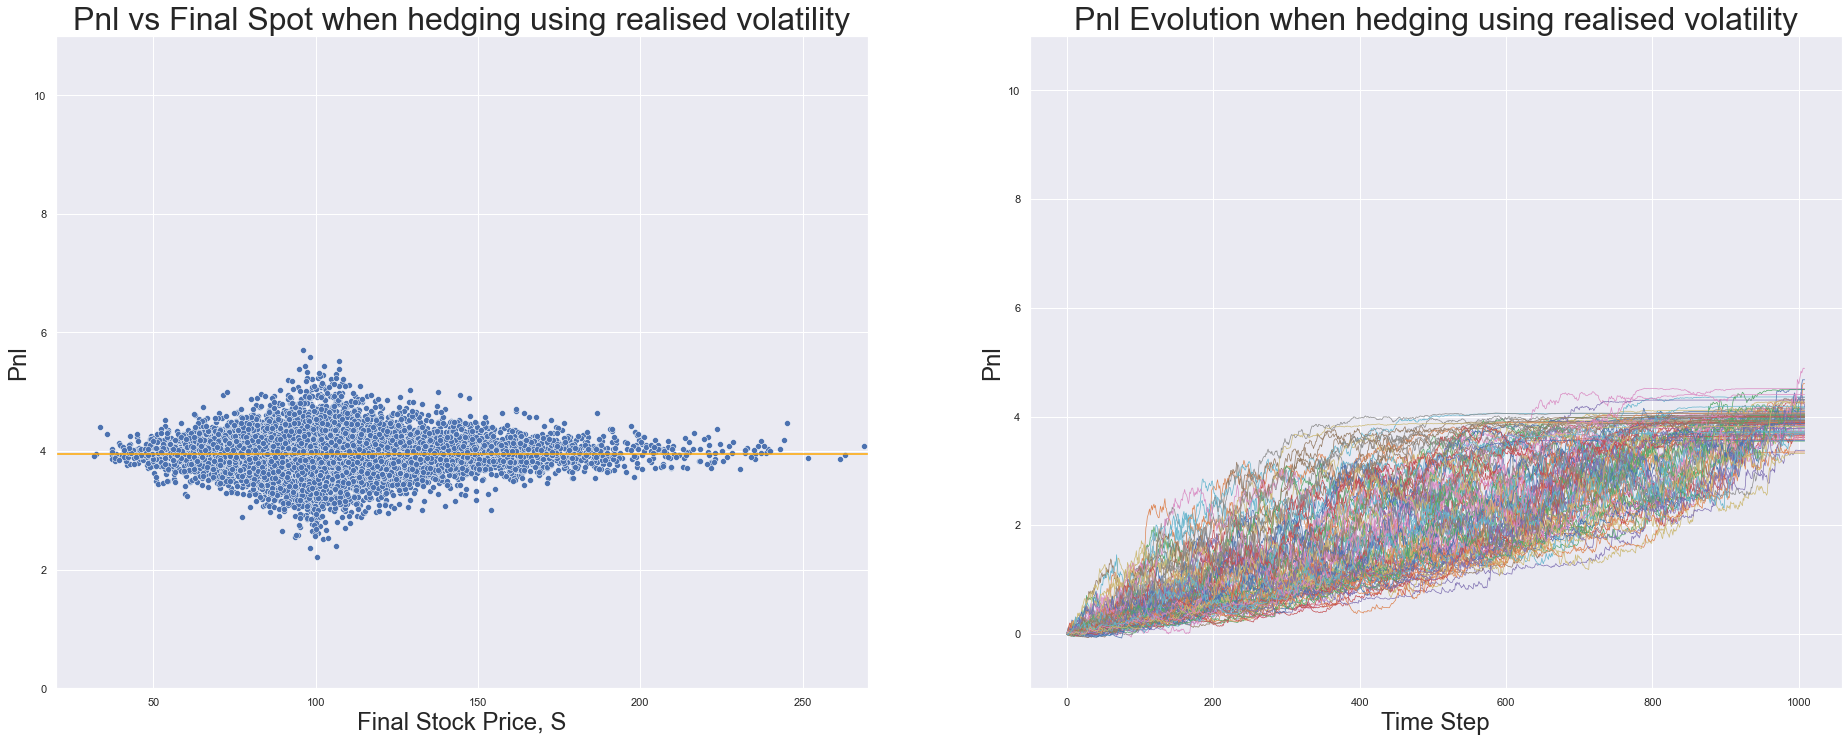

In [17]:
hedge_vol = 0.30

# compute all replication data
pxs, rets, call_pxs, repls, deltas, gammas = run_delta_hedge_sim(px, strike, risk_free, divs, sigma, years, points, sims, iv=iv, hedge_vol=hedge_vol)

prices = pxs[:, -1]
call_prices = call_pxs[:, -1]
repl_pxs = repls[:, -1]

fig, axes = plt.subplots(ncols=2, figsize=(32,12))
axes = axes.reshape(-1)

sns.scatterplot(prices, call_prices - repl_pxs, ax=axes[0])

axes[0].axhline(np.mean(call_prices - repl_pxs), color='orange')
axes[0].set_title('Pnl vs Final Spot when hedging using realised volatility', fontsize=32)
axes[0].set_xlabel('Final Stock Price, S', fontsize=24)
axes[0].set_ylabel('Pnl', fontsize=24)
axes[0].set_xlim(20, 270)
axes[0].set_ylim(0, 11)

pd.DataFrame(call_pxs[:100, :] - repls[:100, :]).T.plot(ax=axes[1], legend=False, lw=0.7)
axes[1].set_title('Pnl Evolution when hedging using realised volatility', fontsize=32)
axes[1].set_xlabel('Time Step', fontsize=24)
axes[1].set_ylabel('Pnl', fontsize=24)
axes[1].set_ylim(-1, 11);

How does this compare to the two graphs we had before? I've normalised the scales so we can compare easily and a few observations are immediate:
 - the scatterplot seems to show that apart from the hedging error we have from discrete hedging (instead of continuous), we have a constant pnl of around `4`
 - our pnl evolution is much more erratic and not at all monotonically increasing like we had for implied volatility

So it seems like when we use realised instead of implied we generate 2 very different sets of:
 - final pnl distributions: implied volatility generates a peak around the option strike whereas realised generates a constant pnl
 - pnl evolutions: implied generates monotonically increasing pnl whereas realised is more erratic with lots of down days

Which then begs the question:

## Which is better?

Given the above choice between a constant pnl (using realised volatility to hedge) vs a distribution (using implied volatility) I personally would prefer the less risky option and go with realised volatility. This way you can be sure that you'll make a certain pnl regardless of where the stock price ends up relative to your strike.

__However this is only in the idealised world we constructed where we know what the final realised volatility will be over the life of the option.__ In practise this is not the case as we don't have a crystal ball and no amount of ARCH or GARCH modelling will manage to consistently predict this correctly. In reality we don't know in advance whether realised volatility will be higher than implied. In these situations using realised volatility has a very clear drawback - the volatility of the pnl evolutions.

## Mark to Market (MTM)

Trading desks can't just:
 - buy things
 - say they went up
 - say they made lots of money

although that does sound pretty fun. In reality there are checks in place to ensure that books are 'being marked correctly'. In practise this is an implementation of the phrase 'something is only worth what someone else is willing to pay for it' and means that the daily pnl of a position is calculated based on what we observe its price to be in the market. You can't say something is worth `100` if people are only willing to pay `50` for it right now.

As a result even if we have a model that says we are 'guaranteed' to make `x` by the end of the trade (like we have above for hedging with realised volatility), __we still need to value our position each day using the market value, not the model value.__

The above is what generates the erratic pnl evolution for the case where we computed the delta using realised volatility. This is because:
 - the option value evolves according to the implied volatility computed delta (mark to market)
 - the replication value evolves according to the realised volatility computed delta

with the divergence between these two quantities generating a divergence between the portfolio values. If we don't care about this erratic nature e.g. because we don't have risk/loss limits, then potentially hedging using realised is still preferred. However the requirement to manage this daily mark to market (MTM) along with the lack of knowledge of what the actual realised volatility will be __means that computing deltas using implied volatility appears like a real winner.__

## Why is the implied pnl distribution peaked around strike?

So now that we've established that using implied volatility is probably the one that makes the most sense, let's try to dig into why the distribution of pnl looks the way it looks. If we can't change the fact that we won't know what our final pnl will be, then at least we can try to understand why it looks the way it looks.

As mentioned at the start, we make money when realised is higher than implied because we make more money from the continuous rebalancing of our delta hedge than we lose from the option decaying away its time value. Given a fixed realised volatility of `30` (which controls how much the spot moves) and a fixed implied vol of `20` (which controls how much our time value decays each day) we are left with the following question:

_"What controls how much money we make on a given day from this realised being higher than implied?"_

__The answer to this is gamma.__ Gamma is defined as how much our delta changes for a given move in the underlying stock price - it is a statement about how variable our delta is and as we looked at in Part II - when we have bought options, the more our delta changes the better because that means for a given stock price move we need to trade more stocks to re-hedge. And the more stocks we trade as we continuously rebalance then the more we will make from the buy-low / sell-high delta rebalancing.

Put differently, even if the realised volatility is much much higher than the implied volatility I wouldn't care in the slightest if I didn't have any gamma. This is because if I'm in a region of the payoff where my delta is basically constant (so very in-the-money (ITM) or very out-of-the-money (OTM)) then no matter what size of spot move (high realised vol) my delta won't change. And if my delta doesn't change then I'm not re-hedging. And if I'm not re-hedging then I'm not making any money on the re-hedging behaviour.

So really what matters is not just getting it right - that realised will be higher than implied - __but then also ensuring when that manifests itself through spot price moves we have gamma so we can profit from the moves.__

## Where is gamma the highest?

__Around the strike and when we have little time left to expiry.__ As a result, those paths where we end up close to the strike near expiry generate the highest pnl because we have lots of gamma when we are experiencing realised volatility higher than implied. To show this, we can take our previous scatterplot and partition it based on the average gamma per path - where we would expect those with lots of gamma to be centred around the strike.

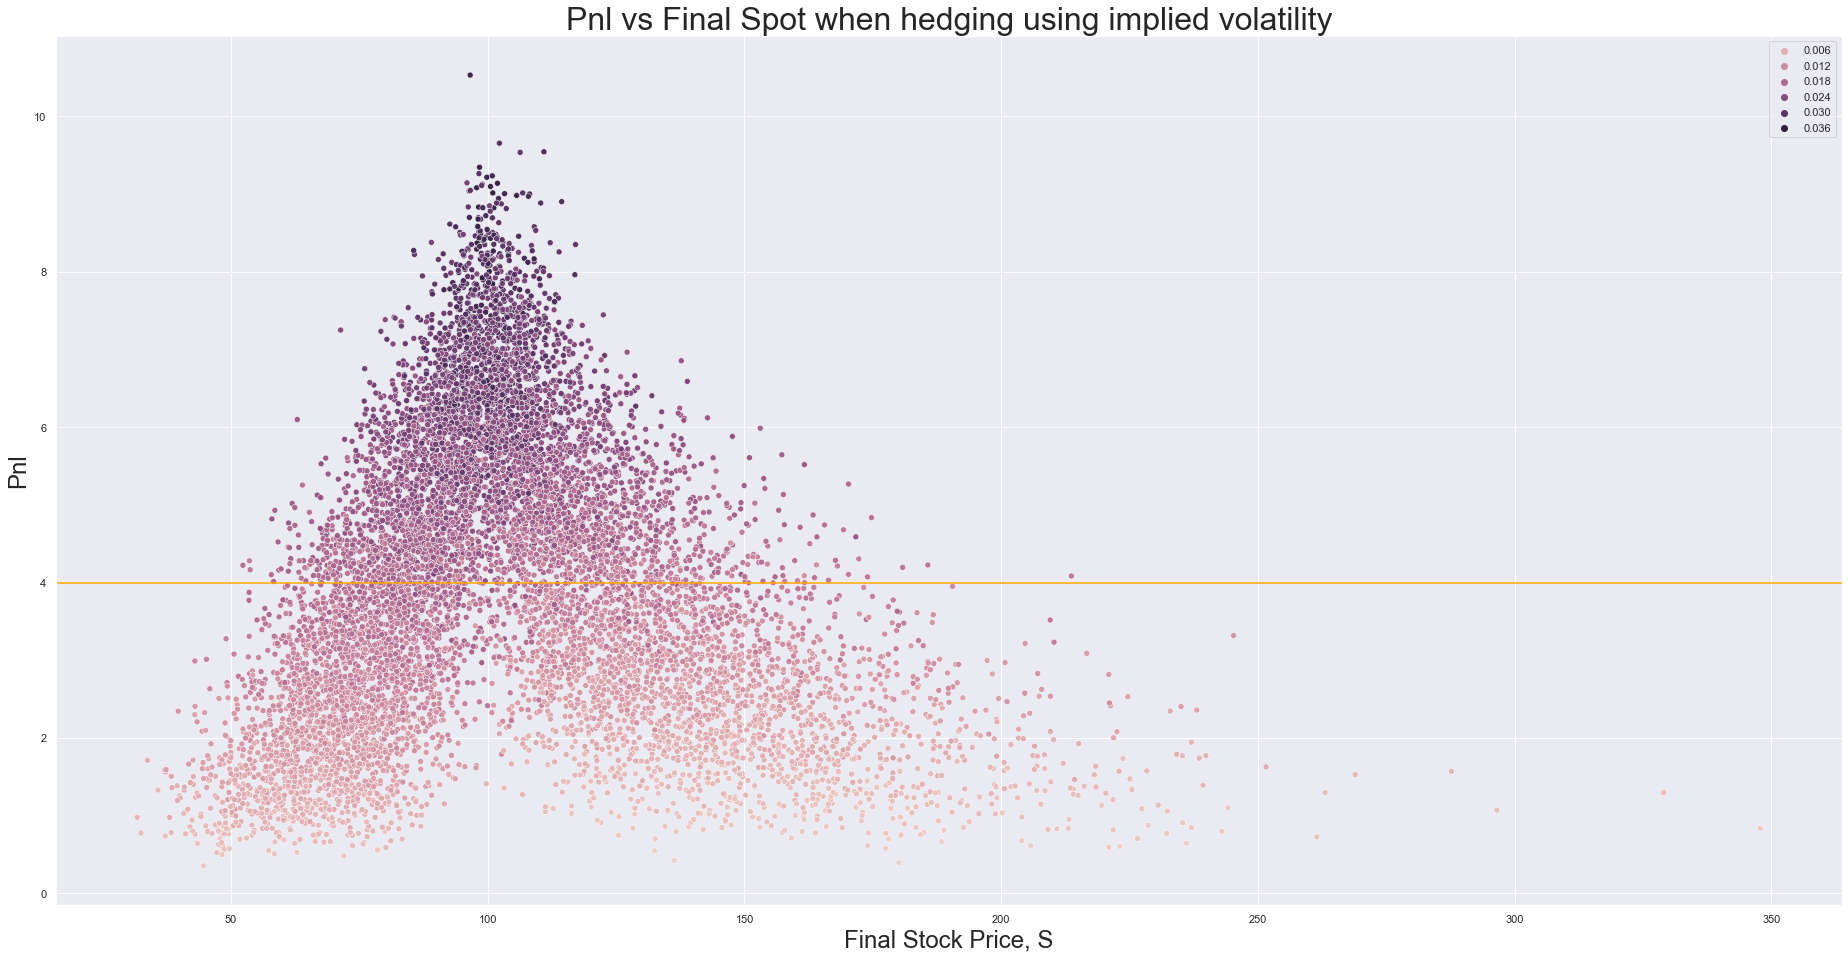

In [18]:
# reset to hedge using implied vol
hedge_vol = 0.20

# compute all replication data
pxs, rets, call_pxs, repls, deltas, gammas = run_delta_hedge_sim(px, strike, risk_free, divs, sigma, years, points, sims, iv=iv, hedge_vol=hedge_vol)

# get quantities for plotting
prices = pxs[:, -1]
call_prices = call_pxs[:, -1]
repl_pxs = repls[:, -1]
gamma_hue = np.mean(gammas[:,:-1], axis=1)

# plot
fig, ax = plt.subplots(figsize=(32,16))
sns.scatterplot(prices, call_prices - repl_pxs, ax=ax, hue=gamma_hue)

# label
ax.axhline(np.mean(call_prices - repl_pxs), color='orange')
ax.set_title('Pnl vs Final Spot when hedging using implied volatility', fontsize=32)
ax.set_xlabel('Final Stock Price, S', fontsize=24)
ax.set_ylabel('Pnl', fontsize=24);

So just as before we have a distribution of final pnls centred around the strike, however now we have the dots coloured based on their average daily gamma throughout the life of the simulation. As expected, the simulations generating the most pnl are those with the highest average gamma, because that's generating greater delta changes for a given realised volatility.

## Does it swing both ways?

Just before wrapping up, let's just ensure that it works both ways - if we buy an option and the realised volatility is lower than the implied volatility, does the distribution of losses peak (or trough??) around the strike?

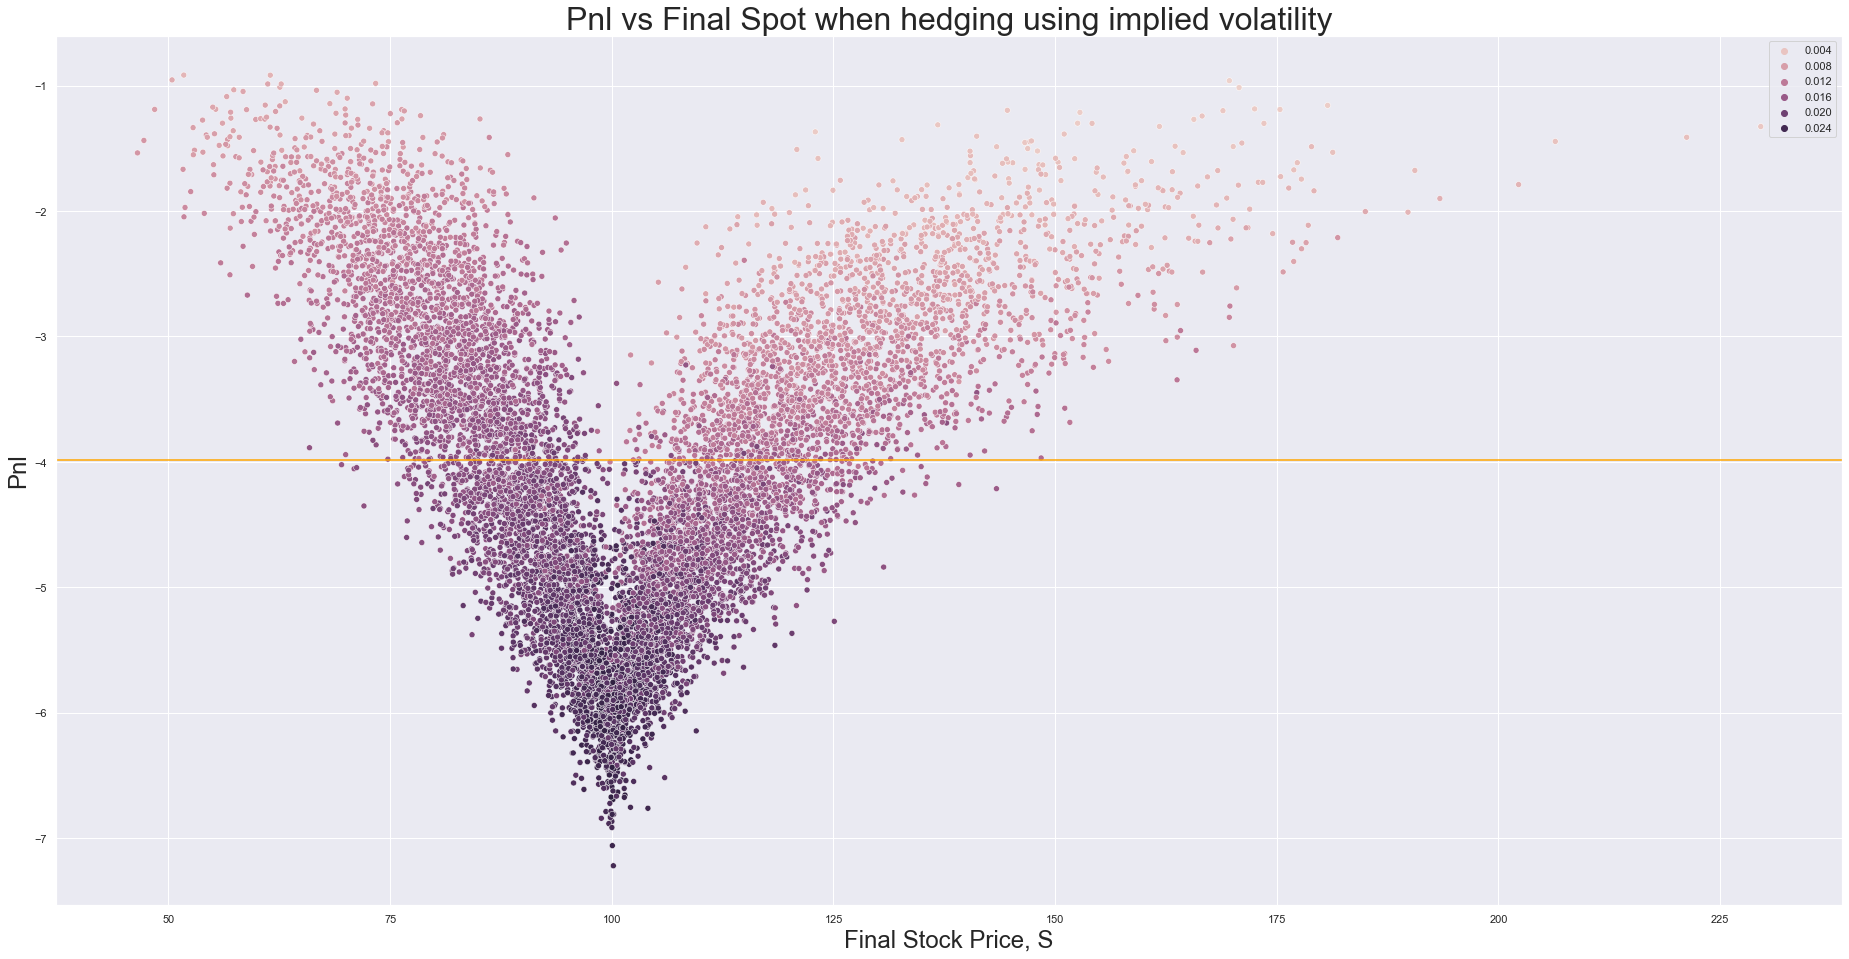

In [19]:
# set implied vol and use that as vol to compute hedge
sigma = 0.20
iv = 0.30
hedge_vol = 0.30

# compute all replication data
pxs, rets, call_pxs, repls, deltas, gammas = run_delta_hedge_sim(px, strike, risk_free, divs, sigma, years, points, sims, iv=iv, hedge_vol=hedge_vol)

# get quantities for plotting
prices = pxs[:, -1]
call_prices = call_pxs[:, -1]
repl_pxs = repls[:, -1]
gamma_hue = np.mean(gammas[:,:-1], axis=1)

# plot
fig, ax = plt.subplots(figsize=(32,16))
sns.scatterplot(prices, call_prices - repl_pxs, ax=ax, hue=gamma_hue)

# label
ax.axhline(np.mean(call_prices - repl_pxs), color='orange')
ax.set_title('Pnl vs Final Spot when hedging using implied volatility', fontsize=32)
ax.set_xlabel('Final Stock Price, S', fontsize=24)
ax.set_ylabel('Pnl', fontsize=24);

It seems like the answer is yes - if we overestimate volatility and assume that realised will be higher than implied (when in fact it is not) then we will lose, with our distribution centred again around the strike.

## Conclusion

As shown above, computing and hedging the resulting deltas based on implied volatility and realised volatility results in 2 very different pnl distributions and evolutions. Due to the need to mark to _market_ (rather than mark to _model_), implied volatility is generally chosen to hedge options. Whilst this results in a smoother pnl evolution it does lead to the problem of not being able to know what your final pnl will be - even if you make the right call vis-a-vis realised vs implied.

We then showed with some pretty scatterplots that what determines where we end up in this pnl distribution is gamma - in particular whether or not our final spot price ends up near our strike, because this is where our gamma peaks. The above is quite a nice illustration of the drawbacks of using vanilla options for trading realised vs implied volatility and why there is a whole suite of volatility related products now in existence.

In particular it shows why instruments such as [variance swaps](https://en.wikipedia.org/wiki/Variance_swap) are so in demand: because they provide constant exposure to the realised vs implied dynamic. They do this because they are structures with constant gamma - no matter where the spot is they exhibit the same gamma which removes the path dependency that is generating the above pnl distributions.

So far all we have looked at is what happens when we have a stochastic underlying price. In other words, the only source of randomness we have is the stock price movement and we have assumed that implied volatility is a constant. Next we'll look at what happens if we relax this assumption in a very simplistic way and if we need to change how we price anything if volatility is treated as stochastic as well.

P.S. if you fancy a more technical simulation-free version of this (just analytical) then [this is great](http://web.math.ku.dk/~rolf/Wilmott_WhichFreeLunch.pdf).